In [ ]:
from osgeo import gdal
import numpy as np

dem_file_path = "/content/D60624ne.pix"

In [ ]:
dem_dataset = gdal.Open(dem_file_path)
if dem_dataset is None:
    print("Could not open the DEM file.")
    exit()

dem_array = dem_dataset.GetRasterBand(1).ReadAsArray()

In [ ]:
def fill_algorithm(dem):
    # Get the dimensions of the DEM array
    rows, cols = dem.shape

    # Create a copy of the DEM array to store the filled values
    filled_dem = dem.copy()

    # Calculate border values
    border_values = [dem[0, :], dem[-1, :], dem[:, 0], dem[:, -1]]
    border_values = np.concatenate(border_values)
    border_values = border_values[~np.isnan(border_values)]

    # Fill NaN values with the mean of border values
    filled_dem[np.isnan(filled_dem)] = np.mean(border_values)

    # Fill algorithm
    changed = True  # Condition for changes in the array
    while changed:
        changed = False
        min_index = np.unravel_index(np.nanargmin(filled_dem), filled_dem.shape)
        min_value = filled_dem[min_index]

        # If there are no valid values left, break out of the loop
        if np.isnan(min_value):
            break

        # Define neighboring pixels
        neighbors = [(min_index[0] - 1, min_index[1]),
                     (min_index[0] + 1, min_index[1]),
                     (min_index[0], min_index[1] - 1),
                     (min_index[0], min_index[1] + 1)]

        # Iterate over neighboring pixels
        for neighbor in neighbors:
            if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols:
                neighbor_value = filled_dem[neighbor]
                # Update neighbor value if it's NaN or greater than the minimum value
                if np.isnan(neighbor_value) or neighbor_value > min_value:
                    filled_dem[neighbor] = min_value
                    changed = True  # When a change is made, update the condition to True

    return filled_dem


In [ ]:
filled_dem_array = fill_algorithm(dem_array)

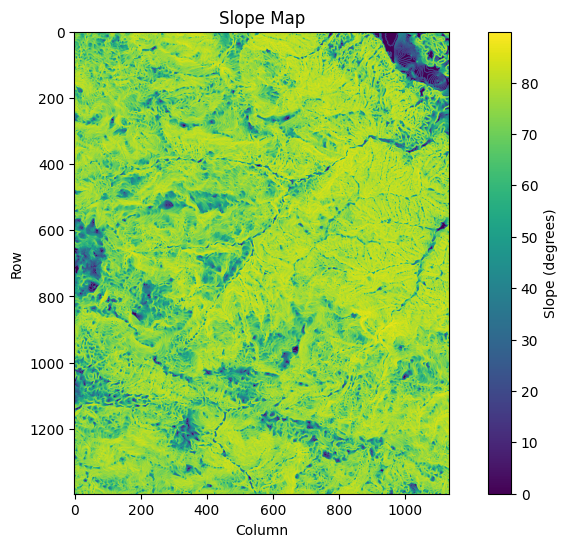

In [ ]:
import numpy as np

def calculate_slope(filled_dem, cell_size):
    # Calculate the vertical difference in elevation between neighboring cells
    dz_dy, dz_dx = np.gradient(filled_dem, cell_size, cell_size)

    # Calculate slope using the vertical difference
    slope_degrees = np.arctan(np.sqrt(dz_dx ** 2 + dz_dy ** 2)) * (180 / np.pi)

    return slope_degrees

# Cell size (assuming square cells)
cell_size = 1  # You need to define your actual cell size here

# Calculate slope
slope_degrees = calculate_slope(filled_dem_array, cell_size)

# Display the slope map
plt.figure(figsize=(10, 6))
plt.imshow(slope_degrees, cmap='viridis')
plt.colorbar(label='Slope (degrees)')
plt.title('Slope Map')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()


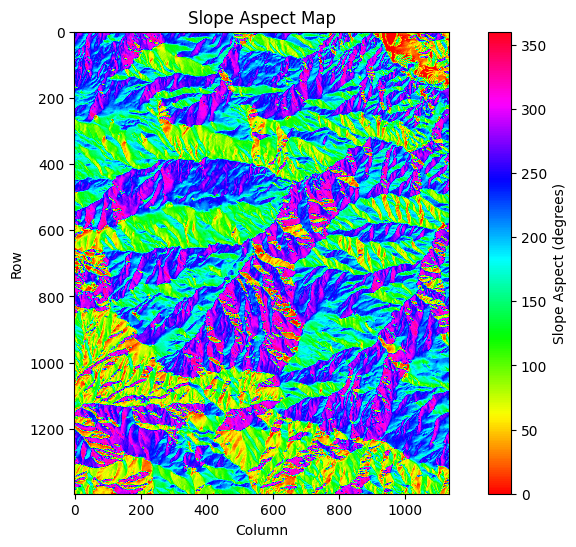

In [ ]:
import numpy as np

def calculate_slope_aspect(filled_dem):
    # Calculate the vertical and horizontal differences in elevation between neighboring cells
    dz_dy, dz_dx = np.gradient(filled_dem)

    # Calculate slope aspect using the vertical and horizontal differences
    slope_aspect = np.arctan2(-dz_dy, dz_dx) * (180 / np.pi)

    # Convert negative angles to positive values
    slope_aspect[slope_aspect < 0] += 360

    return slope_aspect

# Calculate slope aspect
slope_aspect = calculate_slope_aspect(filled_dem_array)

# Display the slope aspect map
plt.figure(figsize=(10, 6))
plt.imshow(slope_aspect, cmap='hsv', vmin=0, vmax=360)
plt.colorbar(label='Slope Aspect (degrees)')
plt.title('Slope Aspect Map')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()


In [ ]:
print("Slope Aspect Guide:")
print("-------------------")
print("North:       0")
print("Northeast:   0 - 90")
print("East:        90")
print("Southeast:   90 - 180")
print("South:       180")
print("Southwest:   180 - 270")
print("West:        270")
print("Northwest:    270 - 360")


Slope Aspect Guide:
-------------------
North:       0
Northeast:   0 - 90
East:        90
Southeast:   90 - 180
South:       180
Southwest:   180 - 270
West:        270
Northwest:    270 - 360


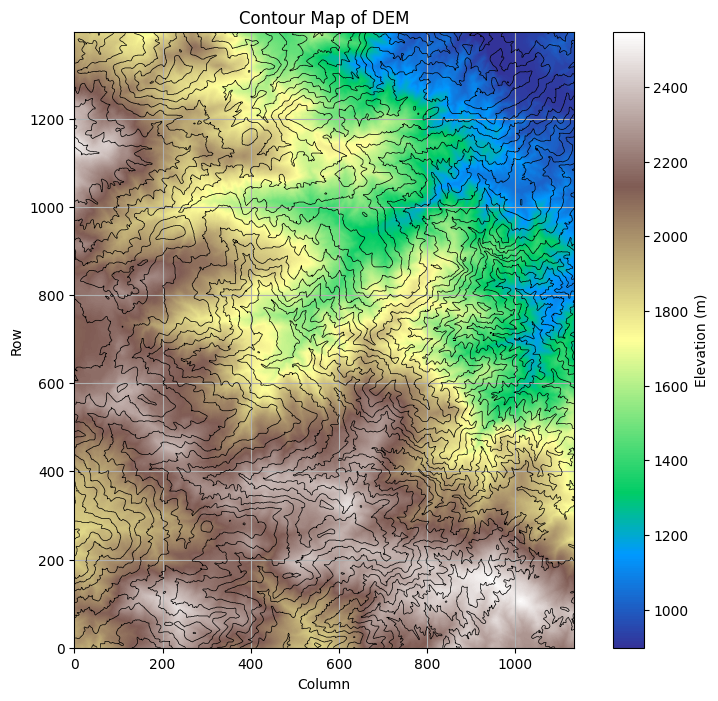

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal

# مسیر فایل DEM
path_to_dem_file = "/content/D60624ne.pix"

# خواندن فایل DEM
dem_data = gdal.Open(path_to_dem_file)
dem_array = dem_data.ReadAsArray()

# دریافت ابعاد DEM
rows, cols = dem_array.shape

# تعیین مقدار X و Y برای نقشه کانتور
x = np.linspace(0, cols, cols)
y = np.linspace(0, rows, rows)

# ایجاد نقشه کانتور
plt.figure(figsize=(10, 8))
plt.contour(x, y, dem_array, 20, colors='black', linewidths=0.5)
plt.imshow(dem_array, cmap='terrain', extent=[0, cols, 0, rows])
plt.colorbar(label='Elevation (m)')
plt.title('Contour Map of DEM')
plt.xlabel('Column')
plt.ylabel('Row')
plt.grid(True)
plt.show()


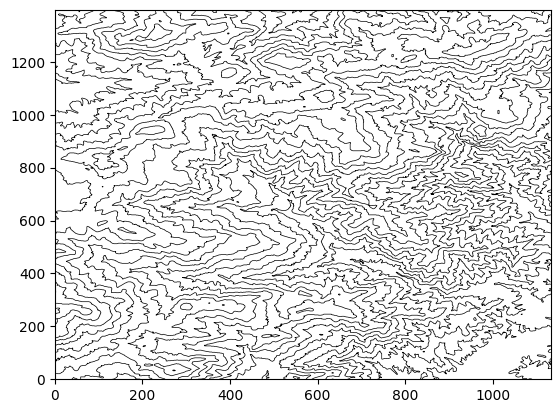

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from shapely.geometry import LineString, mapping
import fiona
from fiona.crs import from_epsg

# دریافت ابعاد DEM
rows, cols = dem_array.shape

# تعیین مقدار X و Y برای نقشه کانتور
x = np.linspace(0, cols, cols)
y = np.linspace(0, rows, rows)

# ایجاد نقشه کانتور
contours = plt.contour(x, y, dem_array, 20, colors='black', linewidths=0.5)

# ایجاد خطوط شیپ فایل از نقشه کانتور
lines = []
for level in contours.collections:
    for path in level.get_paths():
        vertices = path.vertices.tolist()
        lines.append(LineString(vertices))

# ذخیره کردن خطوط به عنوان شیپ فایل
schema = {'geometry': 'LineString', 'properties': {}}
with fiona.open('/content/contours.shp', 'w', 'ESRI Shapefile', schema, crs=from_epsg(4326)) as c:
    for line in lines:
        c.write({'geometry': mapping(line), 'properties': {}})
